<a href="https://colab.research.google.com/github/hrnrhty/my-vae-nnabla/blob/step3/step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3 - オリジナルデータセットの作成

Step 1 では [MNIST](http://yann.lecun.com/exdb/mnist/) データセットを使って VAE (Variational Auto Encoder) の学習を行いました。続く Step 2 では、学習済みパラメータを読み込んで推論を実行しました。Step 2 で確認した通り、VAE は学習に用いたデータの特徴を学習し、学習データに共通して含まれる特徴を再現するような出力データを生成します。しかし、これがいったい何の役に立つのでしょうか？実は、この特性は「異常検知」に応用することができるのです。

異常とは、「正常時にはない特徴」と考えることができます。正常なデータのみを使ってトレーニングされた VAE は、正常データに共通する特徴しか再現できません。このため、推論時に異常が含まれるデータを入力すると、異常箇所が欠落したデータを出力します。つまり、入出力データを比べて差の多い部分が異常であると考えることができるのです。この特性を利用し、入力データと VAE 出力データとを比較することによって、差が大きい部分を異常箇所として可視化したり、その差が一定値以上の時に異常と判定するなど、異常検知アプリケーションに応用することができるのです。

本ステップ以降では、実際に VAE を異常検知に応用していきます。まずはじめに、本ステップではオリジナルのデータセットを作成してみましょう。

## Google Drive のマウント

作成したデータセットの永続化のため Google Drive をマウントします。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 画像の読み込み

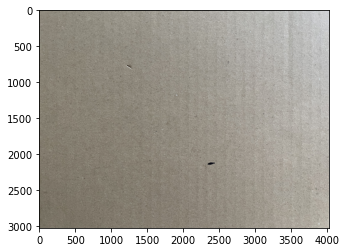

In [2]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open('drive/MyDrive/images/cardboard.jpg')
plt.imshow(im)
plt.show()

読み込んだ画像のサイズを確認してみましょう。下記のコードで、読み込んだ画像は幅 4032、高さ 3024 であることがわかります。

In [3]:
print('(width, height) =', im.size)

(width, height) = (4032, 3024)


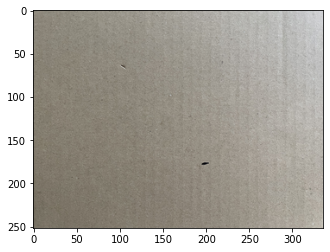

(width, height) = (336, 252)


In [4]:
im_small = im.resize((im.width // 12, im.height // 12), resample=Image.LANCZOS)
plt.imshow(im_small)
plt.show()
print('(width, height) =', im_small.size)

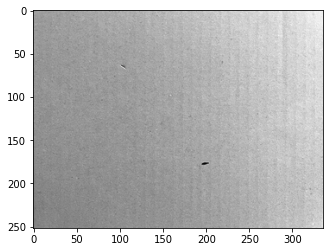

In [5]:
im_gray = im_small.convert('L')
plt.imshow(im_gray, cmap='gray')
plt.show()

In [6]:
width = 28
height = 28
div_h = im_gray.width // width
div_v = im_gray.height // height

imgs = []
for v in range(div_v):
    for h in range(div_h):
        left = h * width
        upper = v * height
        right = (h + 1) * width
        lower = (v + 1) * height
        imgs.append(im_gray.crop((left, upper, right, lower)))
len(imgs)

108

12 9


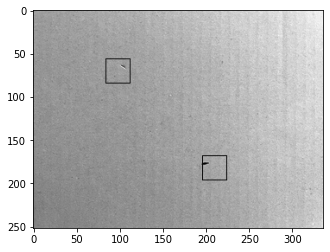

In [7]:
print(div_h, div_v)
from PIL import ImageDraw
draw = ImageDraw.Draw(im_gray)
v, h = (2, 3)  # 3行目4列目傷 idx=27  
draw.rectangle((28*h, 28*v, 28*h+28, 28*v+28), fill=None, outline='black')
v, h = (6, 7)  # 7行目8列目インク idx=79
draw.rectangle((28*h, 28*v, 28*h+28, 28*v+28), fill=None, outline='black')
plt.imshow(im_gray, cmap='gray')
plt.show()

In [8]:
imgs_anomaly = []
imgs_anomaly.append(imgs.pop(79))
imgs_anomaly.append(imgs.pop(27))

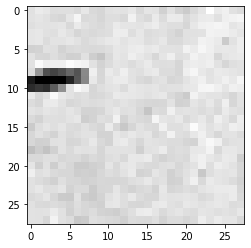

In [9]:
plt.imshow(imgs_anomaly[0], cmap='gray')
plt.show()

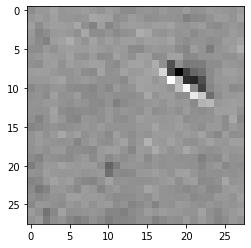

In [10]:
plt.imshow(imgs_anomaly[1], cmap='gray')
plt.show()

In [11]:
!cd drive/MyDrive && if [ ! -d my-vae-nnabla ]; then mkdir my-vae-nnabla; fi
!cd drive/MyDrive/my-vae-nnabla && if [ -d step3 ]; then rm -rf step3; fi && mkdir step3
!cd drive/MyDrive/my-vae-nnabla/step3 && mkdir normal && mkdir anomaly

base_dir = 'drive/MyDrive/my-vae-nnabla/step3'

In [12]:
for i in range(len(imgs)):
    imgs[i].save('{}/normal/{:03d}.png'.format(base_dir, i))

for i in range(len(imgs_anomaly)):
    imgs_anomaly[i].save('{}/anomaly/{:03d}.png'.format(base_dir, i))

In [13]:
import random

random.seed(0)
idx_normal = set(range(106))
idx_test = set(random.sample(idx_normal, 6))
idx_train = list(idx_normal - idx_test)
random.shuffle(idx_train)
idx_test = list(idx_test)

print(idx_train)
print(idx_test)

[14, 24, 99, 25, 9, 74, 98, 70, 17, 51, 46, 61, 68, 3, 103, 23, 39, 11, 50, 31, 2, 52, 45, 72, 43, 63, 26, 37, 94, 30, 77, 57, 90, 88, 20, 7, 100, 91, 83, 62, 6, 29, 36, 85, 58, 15, 95, 81, 4, 105, 21, 48, 16, 22, 89, 32, 87, 0, 78, 92, 54, 56, 80, 104, 12, 1, 8, 35, 71, 60, 102, 75, 27, 42, 59, 101, 86, 76, 64, 44, 10, 93, 41, 19, 82, 73, 34, 84, 13, 96, 38, 18, 69, 28, 79, 47, 66, 40, 55, 67]
[97, 33, 65, 5, 49, 53]


In [14]:
import csv

with open('{}/train.csv'.format(base_dir), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['x:image', 'y:label'])
    for i in idx_train:
        writer.writerow(['./normal/{:03d}.png'.format(i), '0'])

with open('{}/test.csv'.format(base_dir), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['x:image', 'y:label'])
    for i in range(2):
        writer.writerow(['./anomaly/{:03d}.png'.format(i), '1'])
    for i in idx_test:
        writer.writerow(['./normal/{:03d}.png'.format(i), '0'])